In [1]:
# Copilot-written code to parse zgaz_perf.log

import re

log_path = "zgaz_perf_10.log"

# Regular expressions for parsing
iter_re = re.compile(r"Training iteration (\d+) of \d+")
examples_re = re.compile(r"Training on (\d+) examples")
batches_re = re.compile(r"Training with (\d+) batches of size (\d+)")
epoch1_loss_re = re.compile(r"Epoch 1/10, Train Loss: ([\d.]+).*, Train Mean Max: ([\d.]+)")
epoch10_loss_re = re.compile(r"Epoch 10/10, Train Loss: ([\d.]+).*, Train Mean Max: ([\d.]+)")
old_reward_re = re.compile(r"Old network\+MCTS average reward: ([\d.]+)")
new_reward_re = re.compile(r"New network\+MCTS average reward: ([\d.]+)")
old_bare_reward_re = re.compile(r"Old bare network average reward: ([\d.]+)")
new_bare_reward_re = re.compile(r"New bare network average reward: ([\d.]+)")
win_pct_re = re.compile(r"New network won (\d+) and tied (\d+) out of (\d+) games \(([\d.]+)% wins where ties are half wins\)")
decision_re = re.compile(r"(Reverting to the old network|Keeping the new network)")

results = []

with open(log_path, "r") as f:
    entry = {}
    for line in f:
        if m := iter_re.search(line):
            if entry:
                results.append(entry)
                entry = {}
            entry["iteration"] = int(m.group(1))
        if m := examples_re.search(line):
            entry["examples"] = int(m.group(1))
        if m := batches_re.search(line):
            entry["batches"] = int(m.group(1))
        if m := epoch1_loss_re.search(line):
            entry["epoch1_loss"] = float(m.group(1))
            entry["epoch1_mean_max"] = float(m.group(2))
        if m := epoch10_loss_re.search(line):
            entry["epoch10_loss"] = float(m.group(1))
            entry["epoch10_mean_max"] = float(m.group(2))
        if m := old_reward_re.search(line):
            entry["old_reward"] = float(m.group(1))
        if m := new_reward_re.search(line):
            entry["new_reward"] = float(m.group(1))
        if m := old_bare_reward_re.search(line):
            entry["old_bare_reward"] = float(m.group(1))
        if m := new_bare_reward_re.search(line):
            entry["new_bare_reward"] = float(m.group(1))
        if m := win_pct_re.search(line):
            entry["win_pct"] = float(m.group(4))
        if m := decision_re.search(line):
            entry["decision"] = "keep" if "Keeping" in m.group(1) else "revert"
    if entry:
        results.append(entry)

# Example: print the first 3 parsed entries
for r in results[:3]:
    print(r)

{'iteration': 1, 'examples': 64795, 'batches': 32, 'epoch1_loss': 5.9132, 'epoch1_mean_max': 0.03, 'epoch10_loss': 3.5597, 'epoch10_mean_max': 0.0565, 'old_reward': 0.31, 'new_reward': 0.4, 'old_bare_reward': 0.26, 'new_bare_reward': 0.26, 'win_pct': 75.5, 'decision': 'keep'}
{'iteration': 2, 'examples': 129834, 'batches': 64, 'epoch1_loss': 3.8736, 'epoch1_mean_max': 0.0752, 'epoch10_loss': 2.389, 'epoch10_mean_max': 0.2828, 'old_reward': 0.4, 'new_reward': 0.46, 'old_bare_reward': 0.28, 'new_bare_reward': 0.28, 'win_pct': 65.0, 'decision': 'keep'}
{'iteration': 3, 'examples': 194694, 'batches': 96, 'epoch1_loss': 2.4024, 'epoch1_mean_max': 0.3117, 'epoch10_loss': 2.0843, 'epoch10_mean_max': 0.3523, 'old_reward': 0.44, 'new_reward': 0.45, 'old_bare_reward': 0.26, 'new_bare_reward': 0.27, 'win_pct': 53.33, 'decision': 'keep'}


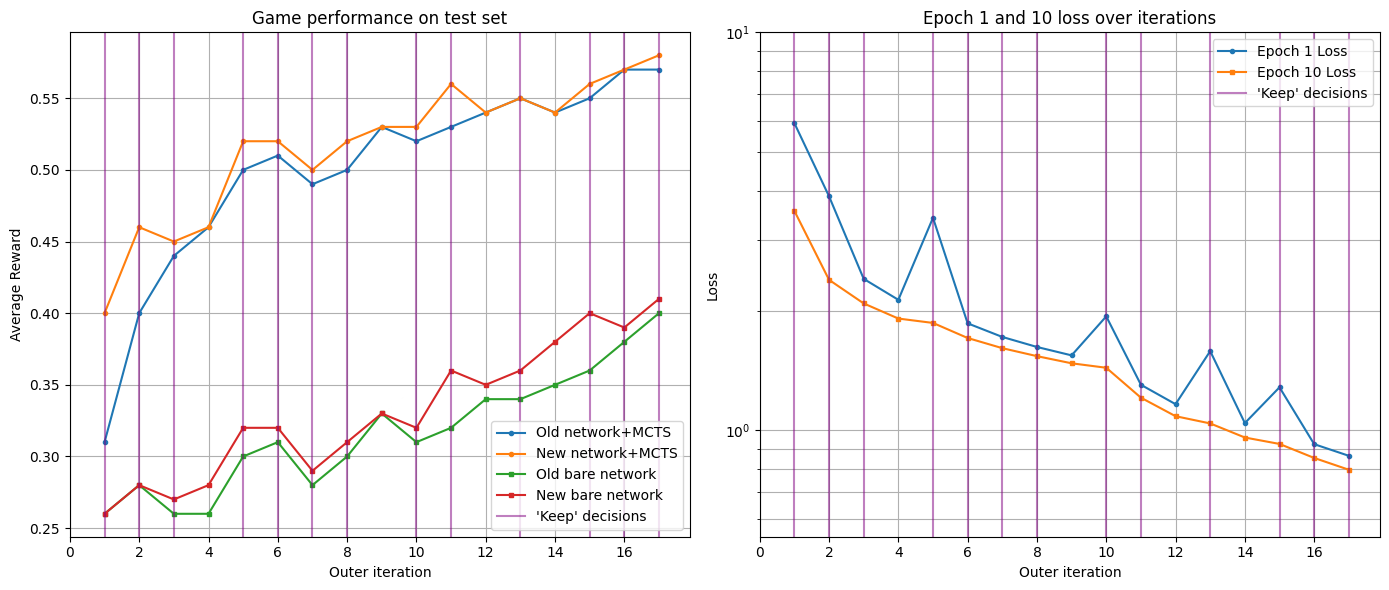

In [2]:
import numpy as np

import matplotlib.pyplot as plt

iterations = [entry['iteration'] for entry in results]
old_rewards = [entry['old_reward'] for entry in results]
new_rewards = [entry['new_reward'] for entry in results]
old_bare_rewards = [entry['old_bare_reward'] for entry in results]
new_bare_rewards = [entry['new_bare_reward'] for entry in results]
win_pcts = [entry['win_pct'] for entry in results]

# Smoothed version using a rolling window (commented out for now)
# window = 2
# smoothed_old = np.convolve(old_rewards, np.ones(window)/window, mode='valid')
# smoothed_new = np.convolve(new_rewards, np.ones(window)/window, mode='valid')
# smoothed_old_bare = np.convolve(old_bare_rewards, np.ones(window)/window, mode='valid')
# smoothed_new_bare = np.convolve(new_bare_rewards, np.ones(window)/window, mode='valid')

keep_iters = [entry['iteration'] for entry in results if entry['decision'] == 'keep']

# Plot rewards (MCTS and bare on same axes)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(iterations, old_rewards, label='Old network+MCTS', marker='o', markersize=3)
plt.plot(iterations, new_rewards, label='New network+MCTS', marker='o', markersize=3)
plt.plot(iterations, old_bare_rewards, label='Old bare network', marker='s', markersize=3)
plt.plot(iterations, new_bare_rewards, label='New bare network', marker='s', markersize=3)

# Smoothed versions (commented out)
# plt.plot(iterations[window//2:window//2+len(smoothed_old)], smoothed_old, label='Smoothed old MCTS', linestyle='--')
# plt.plot(iterations[window//2:window//2+len(smoothed_new)], smoothed_new, label='Smoothed new MCTS', linestyle='--')
# plt.plot(iterations[window//2:window//2+len(smoothed_old_bare)], smoothed_old_bare, label='Smoothed old bare', linestyle='--')
# plt.plot(iterations[window//2:window//2+len(smoothed_new_bare)], smoothed_new_bare, label='Smoothed new bare', linestyle='--')

for ki in keep_iters:
    plt.axvline(x=ki, color='purple', alpha=0.5)

# Add a dummy line for the legend entry
plt.axvline(x=-1, color='purple', alpha=0.5, label="'Keep' decisions")

plt.xlim([0, None])
plt.legend()
plt.xlabel('Outer iteration')
plt.ylabel('Average Reward')
plt.title('Game performance on test set')
plt.grid(True)

# Loss plots
epoch1_losses = [entry['epoch1_loss'] for entry in results]
epoch10_losses = [entry['epoch10_loss'] for entry in results]

# smoothed_epoch1 = np.convolve(epoch1_losses, np.ones(window)/window, mode='valid')
# smoothed_epoch10 = np.convolve(epoch10_losses, np.ones(window)/window, mode='valid')

plt.subplot(1, 2, 2)
plt.plot(iterations, epoch1_losses, label='Epoch 1 Loss', marker='o', markersize=3)
plt.plot(iterations, epoch10_losses, label='Epoch 10 Loss', marker='s', markersize=3)

# Smoothed versions (commented out)
# plt.plot(iterations[window//2:window//2+len(smoothed_epoch1)], smoothed_epoch1, label='Smoothed Epoch 1 Loss', linestyle='--')
# plt.plot(iterations[window//2:window//2+len(smoothed_epoch10)], smoothed_epoch10, label='Smoothed Epoch 10 Loss', linestyle='--')

for ki in keep_iters:
    plt.axvline(x=ki, color='purple', alpha=0.5)

# Add a dummy line for the legend entry
plt.axvline(x=-1, color='purple', alpha=0.5, label="'Keep' decisions")

plt.xlim(left=0)
plt.ylim(top=10.0)
plt.legend()
plt.xlabel('Outer iteration')
plt.ylabel('Loss')
plt.title('Epoch 1 and 10 loss over iterations')
plt.yscale('log')
plt.grid(True, which='both', axis='both')

plt.tight_layout()
plt.show()

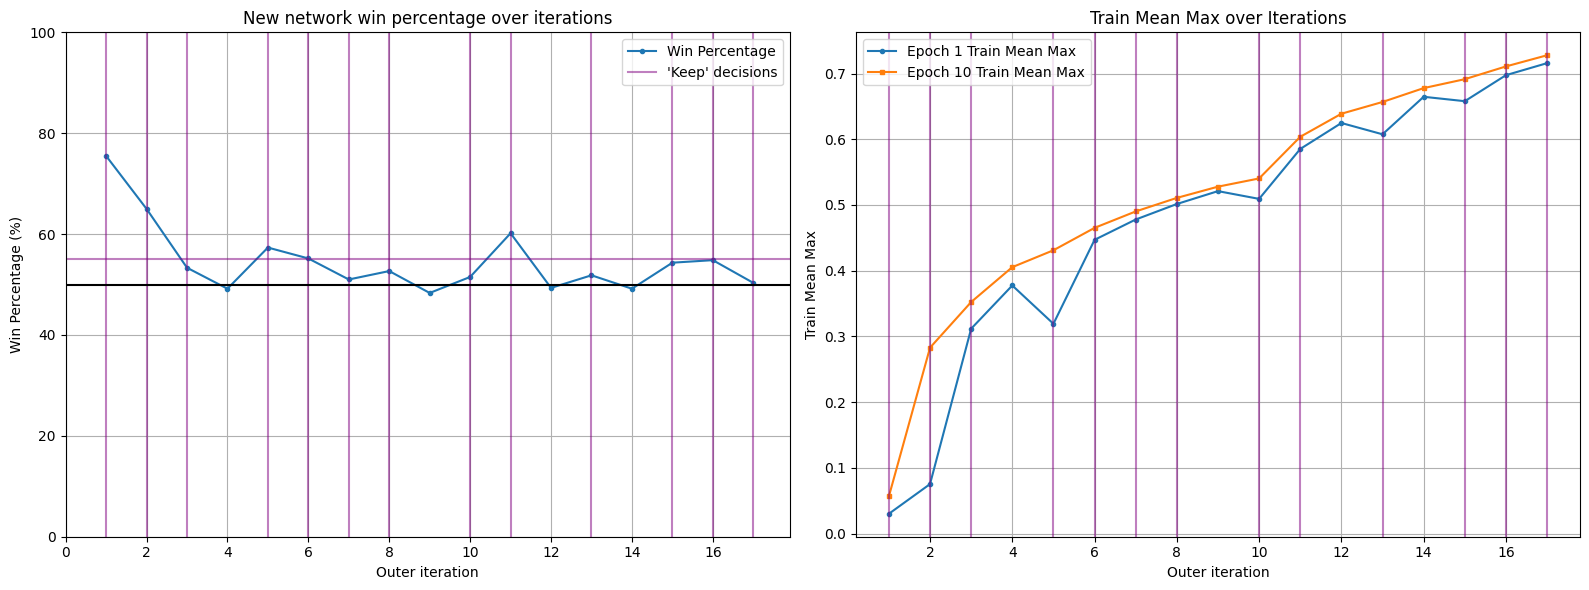

In [3]:
# Combined plot: Win percentage and Train Mean Max over iterations (side by side)
import matplotlib.pyplot as plt

iterations = [entry['iteration'] for entry in results]
win_pcts = [entry['win_pct'] for entry in results]
epoch1_mean_max = [entry.get('epoch1_mean_max', None) for entry in results]
epoch10_mean_max = [entry.get('epoch10_mean_max', None) for entry in results]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Win percentage
axs[0].plot(iterations, win_pcts, label='Win Percentage', marker='o', markersize=3)
for ki in keep_iters:
    axs[0].axvline(x=ki, color='purple', alpha=0.5)
axs[0].axhline(y=55, color='purple', alpha=0.5)
axs[0].axhline(y=50, color='black')
axs[0].axvline(x=-1, color='purple', alpha=0.5, label="'Keep' decisions")
axs[0].set_xlim([0, None])
axs[0].set_ylim([0, 100])
axs[0].legend()
axs[0].set_xlabel('Outer iteration')
axs[0].set_ylabel('Win Percentage (%)')
axs[0].set_title('New network win percentage over iterations')
axs[0].grid(True)

# Subplot 2: Train Mean Max
axs[1].plot(iterations, epoch1_mean_max, label='Epoch 1 Train Mean Max', marker='o', markersize=3)
axs[1].plot(iterations, epoch10_mean_max, label='Epoch 10 Train Mean Max', marker='s', markersize=3)
for ki in keep_iters:
    axs[1].axvline(x=ki, color='purple', alpha=0.5)
axs[1].set_xlabel('Outer iteration')
axs[1].set_ylabel('Train Mean Max')
axs[1].set_title('Train Mean Max over Iterations')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Misc

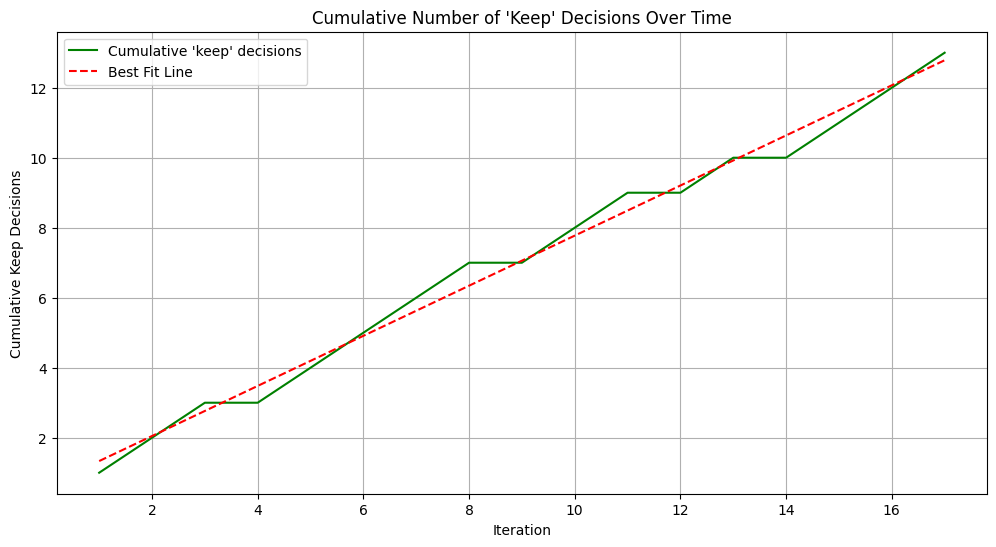

In [4]:
# Calculate cumulative sum of 'keep' decisions over iterations
keep_mask = [1 if entry['decision'] == 'keep' else 0 for entry in results]
cumulative_keep = np.cumsum(keep_mask)

plt.figure(figsize=(12, 6))
plt.plot(iterations, cumulative_keep, label="Cumulative 'keep' decisions", color='green')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Keep Decisions')
plt.title("Cumulative Number of 'Keep' Decisions Over Time")
plt.grid(True)
# plt.legend()
# Plot line of best fit
z = np.polyfit(iterations, cumulative_keep, 1)
p = np.poly1d(z)
plt.plot(iterations, p(iterations), "r--", label="Best Fit Line")
plt.legend()
plt.show()